# Import of Modules

In [9]:
# import moduels
import h5py
import numpy as np
import matplotlib.pylab as plt

from sklearn.model_selection import train_test_split
from sklearn import tree
import pandas as pd
from sklearn.metrics import confusion_matrix

from PIL import Image
import random
import math


# import networks modules
from torchvision import models
import torchvision.transforms as T

# Definitions

In [56]:
# define windowsize
image_size = 256
x_size = image_size
y_size = image_size


#number of samples
n_samples = 100

# number of categories in the pretrained model
n_cat = 21 # only correct for the Pascal Voc data set --> change if other training dataset is used!!!!!

In [11]:
# access the data
# this part have to be replaced when the images from the neuronal networks are available
dset = h5py.File("dataset_test.h5","r")

#Access to the input data
RGB = dset["RGB"]
NIR = dset["NIR"]

In [12]:
#Access groundtruth data
GT = dset["GT"]
CLD = dset["CLD"]

In [69]:
# select model
# available more models are avialable at: https://pytorch.org/vision/stable/models.html

#FCN ResNet50
model = models.segmentation.fcn_resnet50(pretrained=True, progress=True)

#DeepLabV3 ResNet50
#model = models.segmentation.deeplabv3_resnet50(pretrained=True, progress=True)

# Functions

In [13]:
# function to create groundtruth

def groundtruth_generator(img_number, x_ind, y_ind,win_x,win_y):
    #create temp image
    cout_out = GT[img_number, x_ind:x_ind+win_x,y_ind:y_ind+win_y]
    temp_img = np.where(cout_out==99,3,cout_out)

    #insert the clouds into the temp groundtruth
    temp_cloud = CLD[img_number, x_ind:x_ind+win_x,y_ind:y_ind+win_y]
    
    #cloud_positions = np.where(CLD[img_number] > 10) # check if this number makes sense
    cloud_positions = np.where(temp_cloud > 10) # check if this number makes sense
    temp_img[cloud_positions] = 2
    
    #cout_out = temp_img[x_ind:x_ind+win_x,y_ind:y_ind+win_y]

    final_ground = temp_img.reshape(win_x*win_y,1)
    return final_ground

In [14]:
# function to get the samples out of the images
# return window form input image with the specified size
# img_n: number of the image
# x_ind: x-coordinate of top left pixel
# y_ind: y-coordinate of top left pixel
# win_x: size of the window in x direction 
# win_y: size of the window in y direction

# TODO  implement functionality that is possible to choose between the layers
# TODO add the NIR values to the images


def sample_generator(img_n, x_ind, y_ind, win_x, win_y):
    temp_img = RGB[img_n,x_ind:x_ind+win_x,y_ind:y_ind+win_y,:3]
    img = temp_img.reshape(win_x*win_y,3);
    return img

In [15]:
# function to prepare the input image into the correct form (for all segementation models of torchvision the same normalistation and standard deviation can be used!)
# more information: https://learnopencv.com/pytorch-for-beginners-image-classification-using-pre-trained-models/
# or https://pytorch.org/vision/stable/models.html
trf = T.Compose([T.Resize(image_size),
                 T.CenterCrop(image_size),
                 T.ToTensor(), 
                 T.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])

In [70]:
# function to run the network for one image

def run_network (img):
    # prepare image batch
    inp = trf(img).unsqueeze(0)
    # put the image into the network
    out = model(inp)['out']
    
    # reshape the output of the network to use it in the classifier 
    # size (image_size x image_size) x 21 (all of the torchvision segmentation models are trained with the Pascal Voc dataseet --> contains 21 categories) more info: https://pytorch.org/vision/stable/models.html
    # TODO check if the reshape is done in the correct way
    temp = out.detach().numpy()
    temp1 = temp[0]
    temp2 = temp1.reshape(np.square(image_size),n_cat)
    return temp2

# Network part

In [71]:
# create random numbers to for selecting image patches from the three images

#size of the input image
#TODO adapt it for the final version 
s_input = RGB.shape

max_random_x_number = s_input[1]-x_size
max_random_y_number = s_input[2]-y_size

random_x = np.array(random.sample(range(0,max_random_x_number), n_samples))
random_y = np.array(random.sample(range(0,max_random_y_number), n_samples))
random_img = np.random.randint(3,size=n_samples)



In [72]:
# access the random patches with a neuronal network before it


# access the random patches 
# 70 percent is used for training 
# 20 percent is used for validation
# 10 percent is used for testing

per_train = 0.7
per_val = 0.2
per_test = 0.1

#check if this works --> is there never a caser where a patch is lost??
n_train = math.floor(n_samples*per_train)
n_val = math.floor(n_samples*per_val)
n_test = math.floor(n_samples*per_test)

#create empty arrays to store the images Train images

X_train = np.zeros([n_train*(x_size*y_size),n_cat])
y_train = np.zeros([n_train*(x_size*y_size),1])


# TODO add this line to the top
patch_size = x_size*y_size

for i in range(1,n_train-1):
    network_out = run_network(Image.fromarray(RGB[random_img[i-1],random_x[i-1]:random_x[i-1]+x_size,random_y[i-1]:random_y[i-1]+y_size,:3]))
    X_train[(i)*patch_size-patch_size: i*patch_size,:] = network_out
    y_train[(i)*patch_size-patch_size: i*patch_size,:] = groundtruth_generator(random_img[i-1],random_x[i-1], random_y[i-1],x_size, y_size)
    
X_val = np.zeros([n_val*(x_size*y_size),n_cat])
y_val = np.zeros([n_val*(x_size*y_size),1])
for i in range (n_train+1, n_train+n_val-1):
    network_out = run_network(Image.fromarray(RGB[random_img[i-1],random_x[i-1]:random_x[i-1]+x_size,random_y[i-1]:random_y[i-1]+y_size,:3])) 
    X_val[(i-n_train)*patch_size-patch_size: (i-n_train)*patch_size,:] = network_out
    y_val[(i-n_train)*patch_size-patch_size: (i-n_train)*patch_size,:] = groundtruth_generator(random_img[i-1],random_x[i-1], random_y[i-1],x_size, y_size)
    
    
X_test = np.zeros([n_test*(x_size*y_size),n_cat])
y_test = np.zeros([n_test*(x_size*y_size),1])
for i in range (n_train+n_val+1, n_train+n_val+n_test-1):
    network_out = run_network(Image.fromarray(RGB[random_img[i-1],random_x[i-1]:random_x[i-1]+x_size,random_y[i-1]:random_y[i-1]+y_size,:3]))
    X_test[(i-n_train-n_val)*patch_size-patch_size: (i-n_train-n_val)*patch_size,:] = network_out
    y_test[(i-n_train-n_val)*patch_size-patch_size: (i-n_train-n_val)*patch_size,:] = groundtruth_generator(random_img[i-1],random_x[i-1], random_y[i-1],x_size, y_size)
        


# Classifier part

In [73]:
dt_clf = tree.DecisionTreeClassifier(max_depth=5)
dt_clf.fit(X_train, y_train)
dt_clf.score(X_val, y_val)

0.7559524536132812

In [74]:
# test classifier and create confusion matrix
y_pred = dt_clf.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

[[463496      0      0     10]
 [ 64360      0      0      2]
 [ 61955      1      0      0]
 [ 65536      0      0      0]]


# Visualization

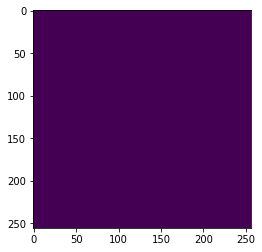

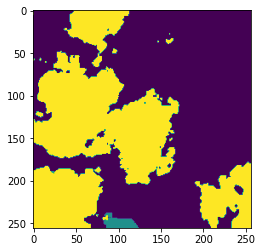

In [77]:
temp = 256*256

temp_img = y_pred[4*temp:5*temp].reshape([256,256])
plt.imshow(temp_img)
plt.show()

groundtruth = y_test[4*temp:5*temp].reshape([256,256])
plt.imshow(groundtruth)
plt.show()